In [1]:
#https://hichoe95.tistory.com/9와 비교하면 재밌을듯

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.autograd import Variable

plt.ion()   # interactive mode

In [3]:
#임의로 8:2로 나눔
#Kaggle dogs and cats
trainset = datasets.ImageFolder(root="./data/dogs-vs-cats/train/",
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
class_names = trainset.classes

testset = datasets.ImageFolder(root="./data/dogs-vs-cats/test/",
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

torch.Size([4, 3, 224, 224]) tensor([0, 1, 0, 0])


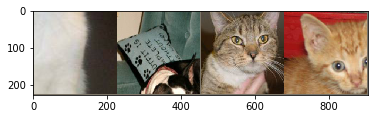

  cat   dog   cat   cat


In [5]:
def imshow(img):
    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) 
    img = unorm(img) # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size(), labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,32,5)
        self.pool = nn.MaxPool2d(2,2)
        self.dout = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,128,5)
        self.conv4 = nn.Conv2d(128,256,5)
        
        self.fc1 = nn.Linear(21*21*256, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.dout(x)
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        x = self.dout(x)
        x = self.pool(F.relu(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dout(x)
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
 
net = Net()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)

In [8]:
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  net = nn.DataParallel(net)
 
if torch.cuda.is_available():
   net.cuda()

lossPlot = []

for epoch in range(40):  # loop over the dataset multiple times

    correct = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        prediction = torch.max(outputs.data,1)[1]
        
        correct += prediction.eq(labels.data.view_as(prediction)).cpu().sum()
        
        if i % 250 == 249:    # print every 250 mini-batches -> 원래 2000
            print('[%d, %5d] loss: %.6f acc : %.6f' % (epoch + 1, i+1, running_loss/250, 100*correct/((i+1)*4)))
            lossPlot.append(running_loss/250)
            running_loss = 0.0

print('Finished Training')

[1,   250] loss: 0.693018 acc : 51.000000
[1,   500] loss: 0.691512 acc : 51.000000
[1,   750] loss: 0.692123 acc : 52.000000
[1,  1000] loss: 0.693053 acc : 51.000000
[1,  1250] loss: 0.691753 acc : 51.000000
[1,  1500] loss: 0.689825 acc : 52.000000
[1,  1750] loss: 0.688581 acc : 52.000000
[1,  2000] loss: 0.683492 acc : 53.000000
[1,  2250] loss: 0.685708 acc : 53.000000
[1,  2500] loss: 0.680751 acc : 53.000000
[1,  2750] loss: 0.682089 acc : 53.000000
[1,  3000] loss: 0.681771 acc : 53.000000
[1,  3250] loss: 0.669709 acc : 54.000000
[1,  3500] loss: 0.679547 acc : 54.000000
[1,  3750] loss: 0.668054 acc : 54.000000
[1,  4000] loss: 0.678010 acc : 55.000000
[1,  4250] loss: 0.665659 acc : 55.000000
[1,  4500] loss: 0.669830 acc : 55.000000
[1,  4750] loss: 0.672924 acc : 55.000000
[1,  5000] loss: 0.677214 acc : 55.000000
[2,   250] loss: 0.670156 acc : 59.000000
[2,   500] loss: 0.669095 acc : 58.000000
[2,   750] loss: 0.661535 acc : 59.000000
[2,  1000] loss: 0.667775 acc : 59

[10,  3750] loss: 0.513381 acc : 75.000000
[10,  4000] loss: 0.489058 acc : 75.000000
[10,  4250] loss: 0.489264 acc : 75.000000
[10,  4500] loss: 0.476317 acc : 75.000000
[10,  4750] loss: 0.487054 acc : 75.000000
[10,  5000] loss: 0.459257 acc : 75.000000
[11,   250] loss: 0.496317 acc : 75.000000
[11,   500] loss: 0.460243 acc : 77.000000
[11,   750] loss: 0.481231 acc : 77.000000
[11,  1000] loss: 0.453048 acc : 77.000000
[11,  1250] loss: 0.466463 acc : 77.000000
[11,  1500] loss: 0.435098 acc : 77.000000
[11,  1750] loss: 0.469953 acc : 77.000000
[11,  2000] loss: 0.470752 acc : 77.000000
[11,  2250] loss: 0.495696 acc : 77.000000
[11,  2500] loss: 0.461213 acc : 77.000000
[11,  2750] loss: 0.475957 acc : 77.000000
[11,  3000] loss: 0.485685 acc : 77.000000
[11,  3250] loss: 0.444869 acc : 77.000000
[11,  3500] loss: 0.458097 acc : 77.000000
[11,  3750] loss: 0.461684 acc : 77.000000
[11,  4000] loss: 0.498160 acc : 77.000000
[11,  4250] loss: 0.474195 acc : 77.000000
[11,  4500]

[20,  1250] loss: 0.350226 acc : 83.000000
[20,  1500] loss: 0.338787 acc : 84.000000
[20,  1750] loss: 0.358196 acc : 84.000000
[20,  2000] loss: 0.361979 acc : 84.000000
[20,  2250] loss: 0.393926 acc : 83.000000
[20,  2500] loss: 0.341605 acc : 83.000000
[20,  2750] loss: 0.357098 acc : 83.000000
[20,  3000] loss: 0.365289 acc : 83.000000
[20,  3250] loss: 0.340938 acc : 83.000000
[20,  3500] loss: 0.358975 acc : 83.000000
[20,  3750] loss: 0.351836 acc : 83.000000
[20,  4000] loss: 0.354325 acc : 83.000000
[20,  4250] loss: 0.334867 acc : 84.000000
[20,  4500] loss: 0.367576 acc : 83.000000
[20,  4750] loss: 0.359075 acc : 83.000000
[20,  5000] loss: 0.358664 acc : 83.000000
[21,   250] loss: 0.360497 acc : 82.000000
[21,   500] loss: 0.348086 acc : 83.000000
[21,   750] loss: 0.352395 acc : 83.000000
[21,  1000] loss: 0.370405 acc : 82.000000
[21,  1250] loss: 0.347328 acc : 83.000000
[21,  1500] loss: 0.366468 acc : 83.000000
[21,  1750] loss: 0.343115 acc : 83.000000
[21,  2000]

[29,  3750] loss: 0.270984 acc : 87.000000
[29,  4000] loss: 0.302894 acc : 87.000000
[29,  4250] loss: 0.314314 acc : 87.000000
[29,  4500] loss: 0.268535 acc : 87.000000
[29,  4750] loss: 0.256621 acc : 87.000000
[29,  5000] loss: 0.275523 acc : 87.000000
[30,   250] loss: 0.253610 acc : 88.000000
[30,   500] loss: 0.268372 acc : 88.000000
[30,   750] loss: 0.286855 acc : 87.000000
[30,  1000] loss: 0.267329 acc : 87.000000
[30,  1250] loss: 0.247307 acc : 88.000000
[30,  1500] loss: 0.278715 acc : 88.000000
[30,  1750] loss: 0.279350 acc : 88.000000
[30,  2000] loss: 0.262008 acc : 88.000000
[30,  2250] loss: 0.275170 acc : 88.000000
[30,  2500] loss: 0.272425 acc : 88.000000
[30,  2750] loss: 0.273858 acc : 88.000000
[30,  3000] loss: 0.261360 acc : 88.000000
[30,  3250] loss: 0.267186 acc : 88.000000
[30,  3500] loss: 0.259675 acc : 88.000000
[30,  3750] loss: 0.277589 acc : 88.000000
[30,  4000] loss: 0.273886 acc : 88.000000
[30,  4250] loss: 0.231589 acc : 88.000000
[30,  4500]

[39,  1250] loss: 0.247256 acc : 89.000000
[39,  1500] loss: 0.242996 acc : 89.000000
[39,  1750] loss: 0.234961 acc : 89.000000
[39,  2000] loss: 0.216794 acc : 89.000000
[39,  2250] loss: 0.227734 acc : 89.000000
[39,  2500] loss: 0.225867 acc : 89.000000
[39,  2750] loss: 0.254716 acc : 89.000000
[39,  3000] loss: 0.221377 acc : 89.000000
[39,  3250] loss: 0.238759 acc : 89.000000
[39,  3500] loss: 0.220780 acc : 89.000000
[39,  3750] loss: 0.252753 acc : 89.000000
[39,  4000] loss: 0.260990 acc : 89.000000
[39,  4250] loss: 0.222429 acc : 89.000000
[39,  4500] loss: 0.245334 acc : 89.000000
[39,  4750] loss: 0.203458 acc : 89.000000
[39,  5000] loss: 0.248624 acc : 89.000000
[40,   250] loss: 0.198764 acc : 92.000000
[40,   500] loss: 0.226564 acc : 90.000000
[40,   750] loss: 0.215460 acc : 90.000000
[40,  1000] loss: 0.250610 acc : 90.000000
[40,  1250] loss: 0.228748 acc : 89.000000
[40,  1500] loss: 0.242483 acc : 89.000000
[40,  1750] loss: 0.230421 acc : 89.000000
[40,  2000]

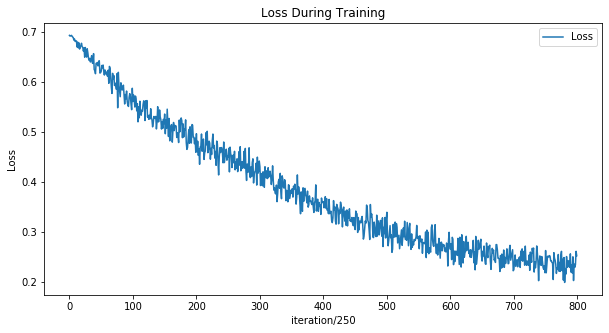

In [9]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(lossPlot,label="Loss")
plt.xlabel("iteration/250")
plt.ylabel("Loss")
plt.legend()
plt.show()

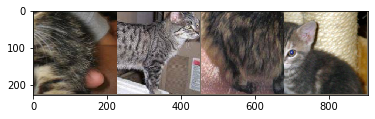

GroundTruth:    cat   cat   cat   cat


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [11]:
images, labels = Variable(images.cuda()), Variable(labels.cuda())
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(4)))

Predicted:    cat   cat   cat   cat


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = Variable(images.cuda()), Variable(labels.cuda())
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 2500 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 2500 test images: 89 %


In [14]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = Variable(images.cuda()), Variable(labels.cuda())
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   cat : 89 %
Accuracy of   dog : 87 %
